In [1]:
import pandas as pd

from config import BASE_DIR

domain = "bible"
gnn_exp_name = "gcn_init"
BASELINE_DIR = f"{BASE_DIR}/experiments/{domain}/baselines"
BASELINE_GNN_DIR = f"{BASE_DIR}/experiments/{domain}/gnn/{gnn_exp_name}"


In [2]:
import os


def list_files(dir):
    filenames = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            filenames.append(file)
    return filenames


print(list_files(BASELINE_DIR))
print(list_files(BASELINE_GNN_DIR))

['book_unsupervised.csv', 'book_supervised.csv']
['gcn_init_book_1_adj_types.csv']


In [3]:
task_by_domain = {"dss": ["book", "composition", "section"], "bible": ["book"]}
tasks = task_by_domain[domain]

gnn_name_format = "{}_{}_1_adj_types.csv"

# Dynamically construct compare_list for tasks in the selected domain
compare_list = {
    task: [
        f"{BASELINE_DIR}/{task}_supervised.csv",
        f"{BASELINE_GNN_DIR}/{gnn_name_format.format(gnn_exp_name, task)}"
    ]
    for task in tasks
}


In [4]:

COMPARISON_SCHEME = ["task", "model", "vectorizer", "test_acc", "weighted_f1", "micro_f1", "macro_f1", "adj_type"]

In [5]:

results = []
for task in tasks:
    baseline = pd.read_csv(compare_list[task][0])
    baseline = baseline.rename(columns={"accuracy": "test_acc"})
    baseline = baseline[baseline["model"].isin(["LogisticRegression", "MLPClassifier"])]
    baseline = baseline.sort_values(by="test_acc", ascending=False)
    baseline["task"] = task
    baseline["adj_type"] = None
    results.append(baseline[COMPARISON_SCHEME].to_dict(orient="records"))

    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model": "vectorizer"})

    max_idx = gnn.groupby('vectorizer')['val_acc'].idxmax()
    max_test_acc_rows = gnn.loc[max_idx]
    max_test_acc_rows["model"] = "GCN"
    max_test_acc_rows["task"] = task
    results.append(max_test_acc_rows[COMPARISON_SCHEME].to_dict(orient="records"))

all_results = pd.DataFrame([item for sublist in results for item in sublist])
all_results

,task,model,vectorizer,test_acc,weighted_f1,micro_f1,macro_f1,adj_type
0,book,MLPClassifier,dicta-il/MsBERT,0.838687,0.835974,0.838687,0.769432,None
1,book,LogisticRegression,dicta-il/MsBERT,0.836592,0.832241,0.836592,0.738799,None
2,book,MLPClassifier,tfidf,0.824721,0.809621,0.824721,0.639458,None
3,book,MLPClassifier,trigram,0.800978,0.791835,0.800978,0.698184,None
4,book,LogisticRegression,trigram,0.775838,0.769281,0.775838,0.672088,None
5,book,LogisticRegression,dicta-il/BEREL,0.766061,0.756979,0.766061,0.630200,None
6,book,MLPClassifier,dicta-il/BEREL,0.762570,0.755792,0.762570,0.647297,None
7,book,LogisticRegression,dicta-il/dictabert,0.733939,0.722712,0.733939,0.587545,None
8,book,MLPClassifier,dicta-il/dictabert,0.720670,0.713924,0.720670,0.591470,None
9,book,LogisticRegression,tfidf,0.708799,0.672439,0.708799,0.411115,None


In [6]:
for task in all_results['task'].unique():
    tmp = all_results[all_results['task'] == task].sort_values(by="test_acc", ascending=False).head(20)
    # tmp.to_csv(f"{BASE_DIR}/reports/tables/{task}_classification_top_20.csv", index=False)


In [7]:

def get_group_by_vectorizer(i):
    if "yonatanlou" in i:
        return 'fine_tuned'
    elif "dicta" in i or "onlplab" in i:
        return 'pre_trained_bert'
    else:
        return 'classic_text_features'


all_results["vectorizer_type"] = all_results["vectorizer"].apply(get_group_by_vectorizer)



In [10]:
# all_results
all_results = all_results[all_results["model"].isin(["GCN", "MLPClassifier"])]
print(pd.pivot_table(all_results, index="model", columns="vectorizer", values="weighted_f1", aggfunc="mean").T.to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
model & GCN & MLPClassifier \\
vectorizer &  &  \\
\midrule
dicta-il/BEREL & 0.81 & 0.76 \\
dicta-il/MsBERT & 0.81 & 0.84 \\
dicta-il/dictabert & 0.81 & 0.71 \\
onlplab/alephbert-base & 0.79 & 0.66 \\
tfidf & NaN & 0.81 \\
trigram & NaN & 0.79 \\
\bottomrule
\end{tabular}


In [106]:

def generate_color_map(df, col, group_name, base_color="PuOr", base_color_by_group=None):
    groups = df.groupby(group_name)[col].apply(list).to_dict()
    num_groups = df[col].nunique()
    all_colors = list(sns.color_palette(base_color, num_groups))
    color_map = {}
    i = 0
    if not base_color_by_group:
        for group, items in groups.items():
            items = list(set(items))

            for item in items:
                color_map[item] = all_colors[i]
                i += 1
        return color_map

    # Function to generate shades of a base color
    def generate_shades(base_color, num_shades):
        # return sns.hls_palette(num_shades, h=base_color, l=0.5, s=0.5)

        return sns.color_palette(base_color, n_colors=num_shades + 1)

    # Create the color map
    color_map = {}
    for group, items in groups.items():
        shades = generate_shades(base_color_by_group[group], len(items))
        for item, shade in zip(items, shades):
            color_map[item] = shade
    return color_map





In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def generate_bar_plot(all_results, x_col, y_col, hue_col, vectorizer_type_col, color_map, filename,
                      which_hue_cols=False, base_color_by_group=None):
    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=len(all_results['task'].unique()), ncols=1,
                             figsize=(12, 6 * len(all_results['task'].unique())), sharey=False)
    all_results['task'] = all_results['task'].replace("section", "sectarian")

    # Create a custom order based on base_color_by_group
    if base_color_by_group:
        custom_order = []
        for group in base_color_by_group.keys():
            group_items = all_results[all_results['vectorizer_type'] == group][hue_col].unique()
            custom_order.extend(group_items)
    else:
        custom_order = None

    # Generate colors for each group
    if base_color_by_group:
        group_colors = {}
        for group, cmap_name in base_color_by_group.items():
            cmap = plt.get_cmap(cmap_name)
            group_colors[group] = cmap(0.6)  # Use a specific point in the colormap

    for i, task in enumerate(all_results['task'].unique()):
        # Filter data for the current task
        task_data = all_results[all_results['task'] == task]
        if which_hue_cols is not None:
            task_data = task_data[task_data[hue_col].isin(which_hue_cols)]

        # Sort the data according to the custom order
        if custom_order:
            task_data[hue_col] = pd.Categorical(task_data[hue_col], categories=custom_order, ordered=True)
            task_data = task_data.sort_values(hue_col)

        # Create the plot with sorted bars
        ax = axes[i] if len(all_results['task'].unique()) > 1 else axes
        sns.barplot(ax=ax, x=x_col, y=y_col, hue=hue_col, data=task_data, palette=color_map, hue_order=custom_order)
        ax.set_title(f'{y_col} by {hue_col} for {task}', fontsize=16)

        # Adjusting the y-axis limits
        min_y_col = task_data[y_col].min()
        max_y_col = task_data[y_col].max()
        padding = (max_y_col - min_y_col) * 0.1
        ax.set_ylim(min_y_col - padding, max_y_col + padding)

        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel(y_col, fontsize=14)
        ax.tick_params(axis='x', rotation=45)

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Vectorizer', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.grid(alpha=0.5)

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_49424/1387938981.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results['task'] = all_results['task'].replace("section", "sectarian")


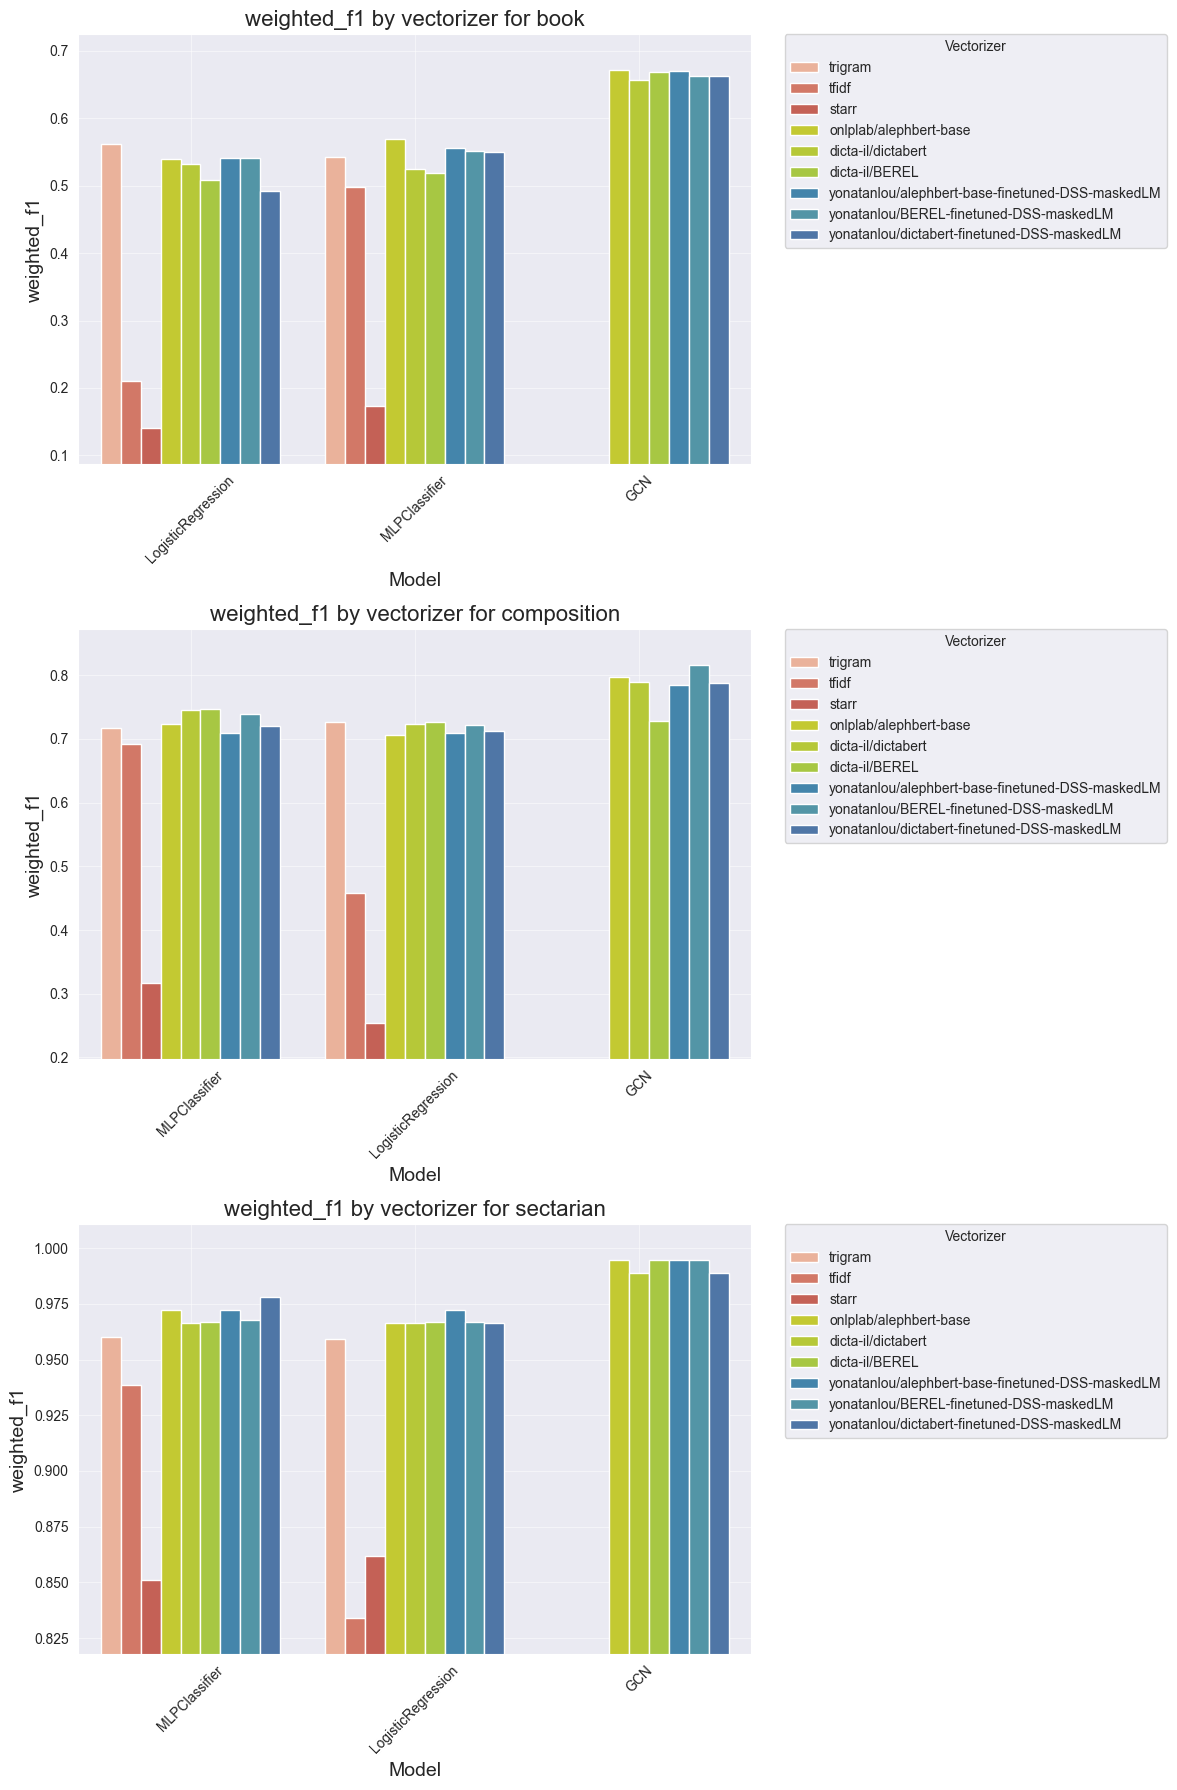

In [108]:
base_color_by_group = {
    'classic_text_features': "coolwarm",  # Red
    'pre_trained_bert': "viridis",  # Green
    'fine_tuned': "Spectral"  # Blue
}

color_map = generate_color_map(all_results, "vectorizer", "vectorizer_type", "RdYlGn", base_color_by_group)

file_name = f"{BASE_DIR}/experiments/dss/gnn/comparsion_plot_all_tasks.png"
file_name = None
# hue_cols = list(all_results[all_results["model"]=="GCN"]["vectorizer"].unique())+["trigram"]
all_results = all_results[all_results["vectorizer"] != "dicta-il/MsBERT"]
hue_cols = all_results["vectorizer"].unique()
plot_obj = generate_bar_plot(all_results, "model", "weighted_f1", "vectorizer", "vectorizer_type", color_map,
                             filename=file_name, which_hue_cols=hue_cols, base_color_by_group=base_color_by_group)

In [68]:

results_gnn = []
for task in tasks:
    gnn = pd.read_csv(compare_list[task][1])
    gnn = gnn.rename(columns={"bert_model": "vectorizer"})

    gnn["model"] = "GCN"
    gnn["task"] = task

    results_gnn.append(gnn.to_dict(orient="records"))

all_results_gnn = pd.DataFrame([item for sublist in results_gnn for item in sublist])
COMPARISON_SCHEME = ["task", "vectorizer", "model", "weighted_f1", "hidden_dim", "adj_type", "learning_rate",
                     "hidden_dim", "epochs"]

MAIN_METRIC = "weighted_f1"
all_results_gnn[all_results_gnn["model"] == "GCN"].sort_values(by=MAIN_METRIC, ascending=False).groupby("task").head(
    5).sort_values(by=["task", MAIN_METRIC], ascending=False)[COMPARISON_SCHEME]


,task,vectorizer,model,weighted_f1,hidden_dim,adj_type,learning_rate,hidden_dim,epochs
0,book,dicta-il/BEREL,GCN,0.787517,500,tfidf,0.001,500,500
9,book,dicta-il/MsBERT,GCN,0.781410,500,tfidf,0.001,500,500
6,book,dicta-il/dictabert,GCN,0.770210,500,tfidf,0.001,500,500
3,book,onlplab/alephbert-base,GCN,0.753068,500,tfidf,0.001,500,500
11,book,dicta-il/MsBERT,GCN,0.713580,500,BOW-n_gram,0.001,500,500
